Large Steps in Inverse Rendering of Geometry
======================================

This is an example on how to use our method for shape optimization with differentiable rendering. It uses `nvdiffrast` for the differentiable rendering part.

In [1]:
import torch
import os
import cupy as cp

from tqdm import trange
from scripts.load_xml import load_scene
from scripts.geometry import (
    compute_vertex_normals, 
    compute_face_normals,
)
from scripts.render import NVDRenderer

# 0. Loading the scene

Let's start by loading a scene

In [2]:
# Load the scene
filepath = os.path.join(os.getcwd(), "data", "scenes", "centered", "centered.xml")
scene_params = load_scene(filepath)

# Load reference shape
v_ref = scene_params["mesh-target"]["vertices"]
n_ref = scene_params["mesh-target"]["normals"]
f_ref = scene_params["mesh-target"]["faces"]

v_ref, n_ref, f_ref = [f.contiguous() for f in [v_ref, n_ref, f_ref]]
# Load source shape
#v = scene_params["mesh-source"]["vertices"]
#f = scene_params["mesh-source"]["faces"]

# 1. Rendering references

Then, we need to setup a differentiable rendering pipeline. Here, we use an implementation based on `nvdiffrast`:

We initialize it once, so it loads the camera data, the environment map and precomputes the shading model, using spherical harmonics in this case.

In [3]:
# Initialize the renderer
renderer = NVDRenderer(scene_params, shading=True, boost=3)

/home/bobi/Desktop/conjure/scripts/render.py:173: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  pos = 0.5 - torch.stack((pos_int % w, pos_int // w), dim=1) / torch.tensor((w,h), device='cuda')


Let's render the target shape to use as a reference for the optimization:

In [4]:
ref_imgs = renderer.render(v_ref, n_ref, f_ref)

Let's look at one of these references

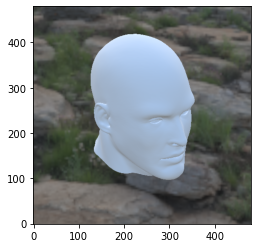

In [5]:
import matplotlib.pyplot as plt
plt.imshow((ref_imgs[7,...,:-1].clip(0,1).pow(1/2.2)).cpu().numpy(), origin='lower')

# 2. Parameterizing

Now it's time to setup the optimization. First, let us import what we need. We need an optimizer, `AdamUniform`, and the functions that allow us to convert back and forth between vertex positions and their parameterization.

In [6]:
steps = 1000 # Number of optimization steps
step_size = 3e-2 # Step size
lambda_ = 19 # Hyperparameter lambda of our method, used to compute the matrix (I + lambda_*L)

Now we need to parameterize our shape. 

In [7]:
#from src.mesh.ellipsoid import Ellipsoid
#from src.mesh.geoid import Geoid
from src.mesh.cube import NetCube
from argparse import Namespace

opt = Namespace(
    n = 82,
    nfc=64, 
    min_nfc=64, 
    ker_size=3,
    num_layer=5,
    stride=1,
    padd_size=0,
    nc_im=3,
)

n = 32
cube = NetCube(n, opt, kernel=7, sigma=2).cuda()
cube.net.load_state_dict(torch.load('./data/net_fitted_n32_c64.pth'))

start = cube.get_start().cuda()

#radii = torch.rand(3, device=v_ref.device, requires_grad=True)
v, f = cube()
# n_ref = compute_face_normals(v_ref, f_ref)
[f.shape for f in [v, f]]

[torch.Size([6144, 3]), torch.Size([12284, 3])]

Let's initialize our optimizer, `AdamUniform`

In [8]:
from largesteps.optimize import AdamUniform

In [9]:
#u.requires_grad = True

#opt = AdamUniform(cube.parameters(), step_size)
opt = torch.optim.Adam(cube.parameters(), 0.0003)

In [10]:
# Dictionary that is returned in the end, contains useful information for debug/analysis
v_steps = torch.zeros((steps+1, *v.shape))#, device='cuda')
losses = torch.zeros(steps+1)#, device='cuda')

# 3. Running the optimization

And now we can run our optimization. The only difference with "regular" optimization here is the call to `from_differential` in the loop body, that converts the parameterization to vertex coordinates. The rest of the optimization pipeline is unchanged.

In [11]:
opt.zero_grad()
#steps = 1000
# Optimization loop
for it in trange(steps):    
    v, f = cube()
    v = v + start
    # Recompute vertex normals
    face_normals = compute_face_normals(v, f)
    n = compute_vertex_normals(v, f, face_normals)

    # Render images
    v, n, f = [f.contiguous()  for f in [v, n, f]]
    opt_imgs = renderer.render(v, n, f)

    # Compute L1 image loss
    loss = (opt_imgs - ref_imgs).abs().mean()

    # Record optimization state for later processing
    with torch.no_grad():
        losses[it] = loss.cpu()
        v_steps[it] = v.cpu()

    # Backpropagate
    opt.zero_grad()
    loss.backward()
    
    # Update parameters
    opt.step()

100%|██████████| 1000/1000 [00:17<00:00, 56.19it/s]


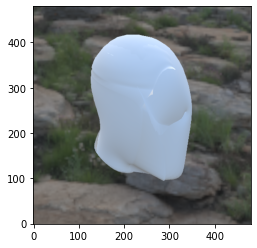

In [12]:
opt_imgs.shape
plt.imshow((opt_imgs[7,...,:-1].detach().clip(0,1).pow(1/2.2)).cpu().numpy(), origin='lower')

In [13]:
with torch.no_grad():
    # Render images
    opt_imgs = renderer.render(v, n, f)
    # Compute L1 image loss
    loss = (opt_imgs - ref_imgs).abs().mean()
    losses[-1] = loss
    v_steps[-1] = v

# 4. Visualizing the results

In [14]:
from meshplot import plot
from ipywidgets import interact
import numpy as np

In [15]:
v_numpy = v_steps.cpu().numpy()
f_numpy = f.cpu().numpy()

In [16]:
shading_params = {
    "width": 600, "height": 600,
    "antialias": True,
    "colormap": "viridis",
    "wireframe": True, "wire_width": 0.03, "wire_color": "black"
}

Let's plot the loss:

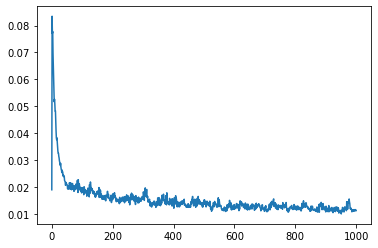

In [17]:
plt.plot(losses.cpu().numpy())

And visualize the mesh across iterations:

In [18]:
@interact(it=(0, steps-1))
def plot_verts(it):
    plot(v_numpy[it], f_numpy, shading=shading_params)

interactive(children=(IntSlider(value=499, description='it', max=999), Output()), _dom_classes=('widget-intera…

In [35]:
import pytorch3d

In [33]:
!conda install -y -c conda-forge torchinfo

Solving environment: done

## Package Plan ##

  environment location: /home/bobi/miniconda3/envs/conjure

  added / updated specs:
    - torchinfo


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    torchinfo-1.6.3            |     pyhd8ed1ab_0          20 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          20 KB

The following NEW packages will be INSTALLED:

  torchinfo          conda-forge/noarch::torchinfo-1.6.3-pyhd8ed1ab_0



torchinfo-1.6.3      | 20 KB     | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done


In [37]:
from torchinfo import summary

model = self.net
batch_size = 16
summary(model, input_size=self.start.shape)



Layer (type:depth-idx)                   Output Shape              Param #
Generator                                --                        --
├─ConvBlock: 1-1                         [6, 256, 72, 72]          --
│    └─Conv2d: 2-1                       [6, 256, 72, 72]          7,168
│    └─BatchNorm2d: 2-2                  [6, 256, 72, 72]          512
│    └─LeakyReLU: 2-3                    [6, 256, 72, 72]          --
├─Sequential: 1-2                        [6, 256, 66, 66]          --
│    └─ConvBlock: 2-4                    [6, 256, 70, 70]          --
│    │    └─Conv2d: 3-1                  [6, 256, 70, 70]          590,080
│    │    └─BatchNorm2d: 3-2             [6, 256, 70, 70]          512
│    │    └─LeakyReLU: 3-3               [6, 256, 70, 70]          --
│    └─ConvBlock: 2-5                    [6, 256, 68, 68]          --
│    │    └─Conv2d: 3-4                  [6, 256, 68, 68]          590,080
│    │    └─BatchNorm2d: 3-5             [6, 256, 68, 68]          512

In [38]:
64**2

4096